In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 数据的读取与展示

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all),(x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[ :5000], x_train_all[5000: ]
y_valid, y_train = y_train_all[ :5000], y_train_all[5000: ]

### 1.1 数据归一化

In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28]  -> [None, 784]
# 注意：在训练数据中的数据归一化用 fit_transform，在验证集和测试集中用的是 transform，这是因为要保证均值和方差一致
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)

## 2. 模型构建

### **2.1 构建架构（批量归一化）**

In [4]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(5):
    model.add(keras.layers.Dense(50, activation="relu"))
    model.add(keras.layers.BatchNormalization())     # 批归一化在激活函数之后
    """
    # 将批归一化放在激活函数之前
    model.add(keras.layer.Dense(100,))
    model.add(keras.layer.BatchNormalization())    # tensorflow将批归一化和
    model.add(keras.layer.Activation("relu"))      # 激活函数实现为一个层
    """
model.add(keras.layers.Dense(10, activation="softmax"))


model.compile(loss="sparse_categorical_crossentropy", optimizer ="sgd", metrics = ["accuracy"])               

### 2.2 查看模型架构

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                2

## 3. 训练模型

In [6]:
# TensorBoard,   EarlyStopping,   ModelCheckpoint
logdir = "./dnn-callbacks"
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir, profile_batch = 100000000),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10, 
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.6866 - accuracy: 0.7670 - val_loss: 0.4532 - val_accuracy: 0.8362
Epoch 2/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.4888 - accuracy: 0.8263 - val_loss: 0.3877 - val_accuracy: 0.8586
Epoch 3/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.4420 - accuracy: 0.8406 - val_loss: 0.3662 - val_accuracy: 0.8676
Epoch 4/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.4131 - accuracy: 0.8506 - val_loss: 0.3520 - val_accuracy: 0.8732
Epoch 5/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.3937 - accuracy: 0.8584 - val_loss: 0.3444 - val_accuracy: 0.8754
Epoch 6/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.3752 - accuracy: 0.8645 - val_loss: 0.3571 - val_accuracy: 0.8696
Epoch 7/10
55000/55000 [==============================] 

## 4. 查看训练历史

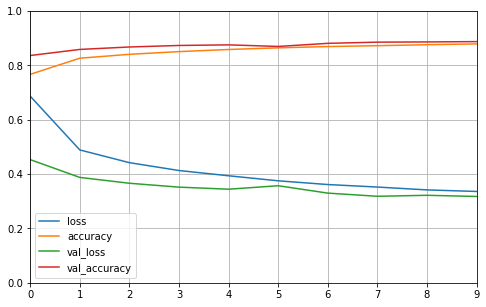

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True) 
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

## 5. 测试数据

In [8]:
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.36007844702005387, 0.8721]